In [316]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import seaborn as sns

import metaspace
import linex2metaspace as lx2m
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from scipy import stats

In [317]:
import utils
from config import store_dir, data_dir, date_key, enrichment_dir
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
ion_lookup = pd.read_csv('/g/alexandr/tim/metaspace_evaluation/backups/ion.tsv', sep='\t', header=None).rename(columns={0:'id', 1:'ion', 2:'formula', 3:'adduct', 4:'charge', 7:'ionFormula'}).drop(columns=[5,6])

/tmp/ipykernel_484/1630403933.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  ion_lookup = pd.read_csv('/g/alexandr/tim/metaspace_evaluation/backups/ion.tsv', sep='\t', header=None).rename(columns={0:'id', 1:'ion', 2:'formula', 3:'adduct', 4:'charge', 7:'ionFormula'}).drop(columns=[5,6])


In [6]:
pos_lip_top_datasets = pickle.load(open(os.path.join(store_dir, 'pos_lip_top_datasets_list.pickle'), "rb" ))

In [55]:
pos_lip_top_datasets

{'Kidney': 2022-12-07_02h13m50s    39
 2022-12-07_02h13m20s    39
 2022-12-07_02h10m45s    39
 2022-12-07_02h09m41s    39
 2022-12-07_02h08m52s    39
                         ..
 2016-12-20_17h39m05s    38
 2016-12-21_09h49m12s    37
 2016-12-21_14h25m44s    38
 2017-12-19_19h07m46s    38
 2018-04-09_23h21m32s    38
 Length: 137, dtype: int64,
 'Brain': 2022-08-24_00h20m06s    38
 2022-08-23_23h48m59s    39
 2022-07-19_19h29m24s    39
 2022-05-31_10h46m34s    40
 2022-05-31_10h27m17s    40
 2022-05-30_20h44m19s    40
 2022-01-31_09h08m54s    40
 2022-01-31_08h54m51s    40
 2021-12-01_13h25m50s    40
 2021-11-11_11h49m37s    40
 2021-11-04_14h12m55s    38
 2021-11-04_11h38m42s    38
 2020-05-19_21h56m17s    38
 2018-08-01_14h26m17s    39
 2018-08-01_14h25m56s    39
 2018-08-01_14h25m21s    39
 2018-08-01_14h24m55s    38
 2018-08-01_14h24m33s    38
 2018-08-01_14h24m14s    38
 2018-08-01_14h21m22s    39
 2018-08-01_14h21m02s    38
 2018-08-01_14h20m46s    38
 2018-08-01_14h20m30s    38
 

In [8]:
dss = pickle.load(open('/g/alexandr/tim/metaspace_evaluation/backups/all_datasets_300922.pickle', 'rb'))

## Load datasets

In [212]:
brain_ads = {}
for ds in pos_lip_top_datasets['Brain'].index:
    brain_ads[ds] = pickle.load(open(os.path.join(store_dir, f'all_ionimages/{ds}.pickle'), "rb" ))
    
    brain_ads[ds] = brain_ads[ds][:, brain_ads[ds].var['offSample'] == False]
    brain_ads[ds] = brain_ads[ds][:, brain_ads[ds].var['fdr'] <= 0.1]

In [213]:
# exclude datasets

del brain_ads['2022-08-24_00h20m06s']
del brain_ads['2022-08-23_23h48m59s']

In [214]:
brain_ads

{'2022-07-19_19h29m24s': View of AnnData object with n_obs × n_vars = 25145 × 186
     obs: 'x', 'y'
     var: 'formula', 'adduct', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'offSample', 'isotopeImages', 'colocCoeff', 'moleculeNames', 'moleculeIds', 'intensity'
     uns: 'spatial', 'metaspace_metadata', 'metaspace_id', 'metaspace_database_details', 'metaspace_config', 'metaspace_name', 'metaspace_adducts', 'metaspace_databases', 'metaspace_group', 'metaspace_polarity', 'metaspace_principal_investigator', 'metaspace_projects', 'metaspace_status', 'metaspace_submitter'
     obsm: 'spatial',
 '2022-05-31_10h46m34s': View of AnnData object with n_obs × n_vars = 73125 × 57
     obs: 'x', 'y'
     var: 'formula', 'adduct', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'offSample', 'isotopeImages', 'colocCoeff', 'moleculeNames', 'moleculeIds', 'intensity'
     uns: 'spatial', 'metaspace_metadata', 'metaspace_id', 'metaspace_dat

# Compute colocs

In [215]:
# Sum molecule intensities over adducts
# Save required info for preprocessing & coloc: Array, y-size, moleculeNames

molecule_names = {}
coloc_dict = {}

for dsid, adat in brain_ads.items():
    
    unique_labels = np.unique(adat.var.formula)
    sums = {}

    # Iterate over the unique labels
    for label in unique_labels:
        # Get the indices of rows with the current label
        indices = np.where(adat.var.formula == label)[0]
        # Sum up the corresponding rows and store the result
        if len(indices)>1:
            sums[label] = np.sum(adat.X[:, indices], axis=1)
        else:
            sums[label] = adat.X[:, indices[0]]
            
        molecule_names[label] = adat.var[adat.var['formula']==label]['moleculeNames'][0]

    tmp_array = np.stack(list(sums.values()))
    tmp_molecules = np.array(list(sums.keys()))
    tmp_ymax = adat.obs['y'].max()+1
    
    # Coloc preprocessing:
    conv_data = utils.coloc_preprocessing_array(tmp_array.transpose(), tmp_ymax)
    
    coloc = pairwise_kernels(conv_data, metric='cosine')
    
    coloc_df = pd.DataFrame(coloc, columns=tmp_molecules, index=tmp_molecules)
    
    coloc_dict[dsid] = coloc_df

In [216]:
cl = []
for dsid, clc in coloc_dict.items():
    tmp = clc.melt().drop(columns=['variable'])
    tmp['ds']=dsid
    cl.append(tmp)

<AxesSubplot: xlabel='value', ylabel='Frequency'>

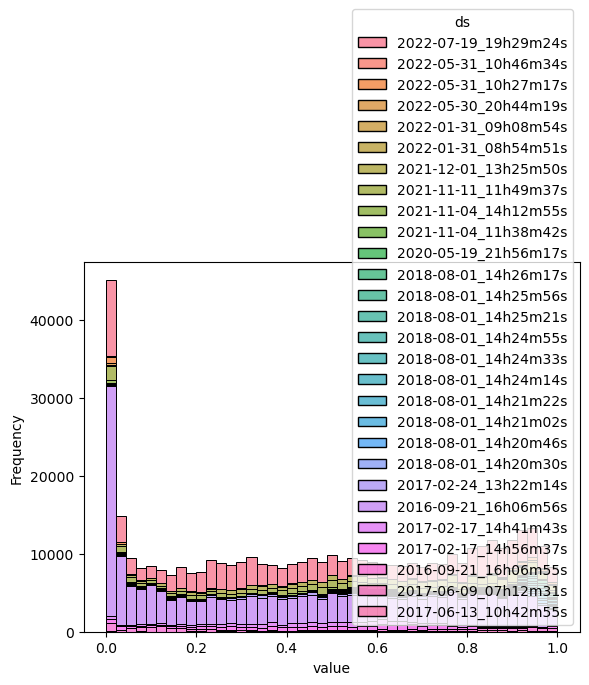

In [217]:
sns.histplot(pd.concat(cl), x='value', hue='ds', multiple='stack', stat='frequency')

## Coloc robustness

In [218]:
ii_dict = {}
for ds in coloc_dict.values():
    idx = list(ds.index)
    for ion1 in range(len(idx)):
        for ion2 in range(ion1, len(idx)):
            if idx[ion1] != idx[ion2]:
                tmp = tuple(sorted([idx[ion1], idx[ion2]]))
                if tmp in ii_dict.keys():
                    ii_dict[tmp].append(ds.loc[idx[ion1], idx[ion2]])
                else:
                    ii_dict[tmp] = [ds.loc[idx[ion1], idx[ion2]]]
                

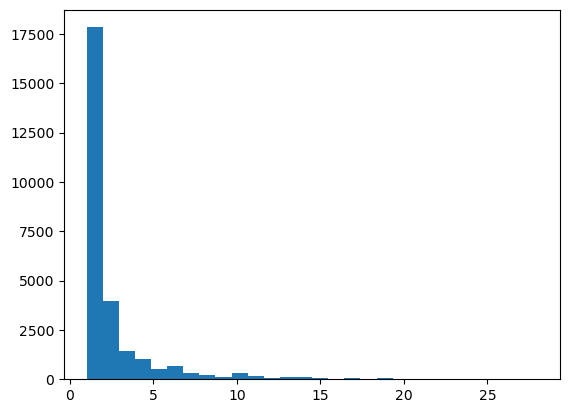

In [226]:
plt.hist([len(x) for x in ii_dict.values()], bins=28)
plt.show()

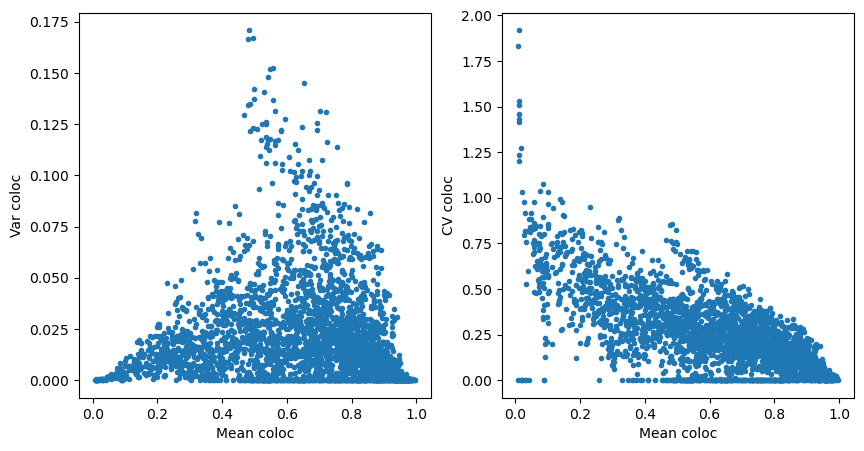

In [231]:
mean_l = []
var_l = []
cv_l = []
min_datasets = 5

for x in ii_dict.values():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_l.append(np.mean(x))
            var_l.append(np.var(x))
            cv_l.append(np.std(x)/np.mean(x))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(mean_l, var_l, '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

ax2.plot(mean_l, cv_l, '.')
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('CV coloc')
plt.show()


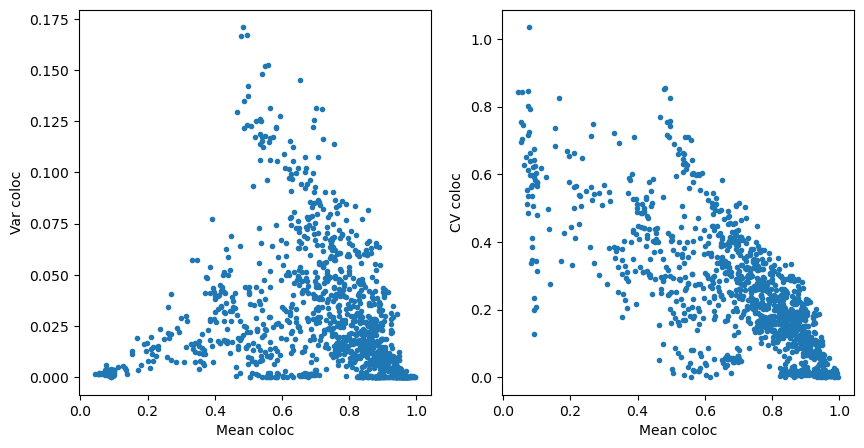

In [235]:
mean_l = []
var_l = []
cv_l = []
min_datasets = 10

counter = 0
for x in ii_dict.values():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_l.append(np.mean(x))
            var_l.append(np.var(x))
            cv_l.append(np.std(x)/np.mean(x))
            counter += 1

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(mean_l, var_l, '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

ax2.plot(mean_l, cv_l, '.')
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('CV coloc')
plt.show()

In [236]:
counter

1175

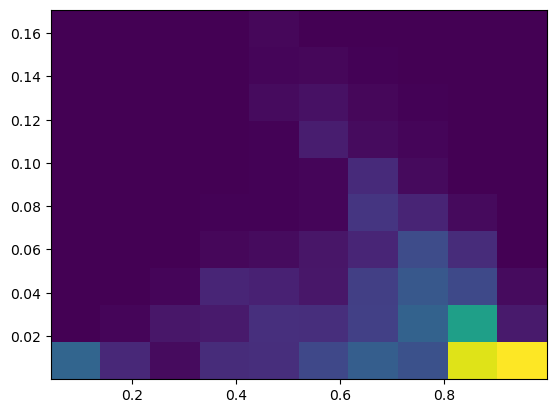

In [222]:
plt.hist2d(mean_l, var_l)
plt.show()

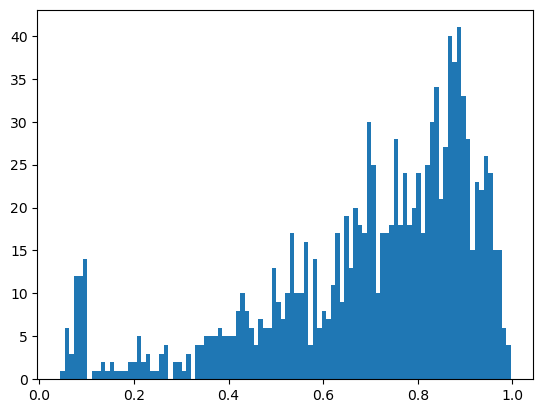

In [223]:
plt.hist(mean_l, bins=100)
plt.show()

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


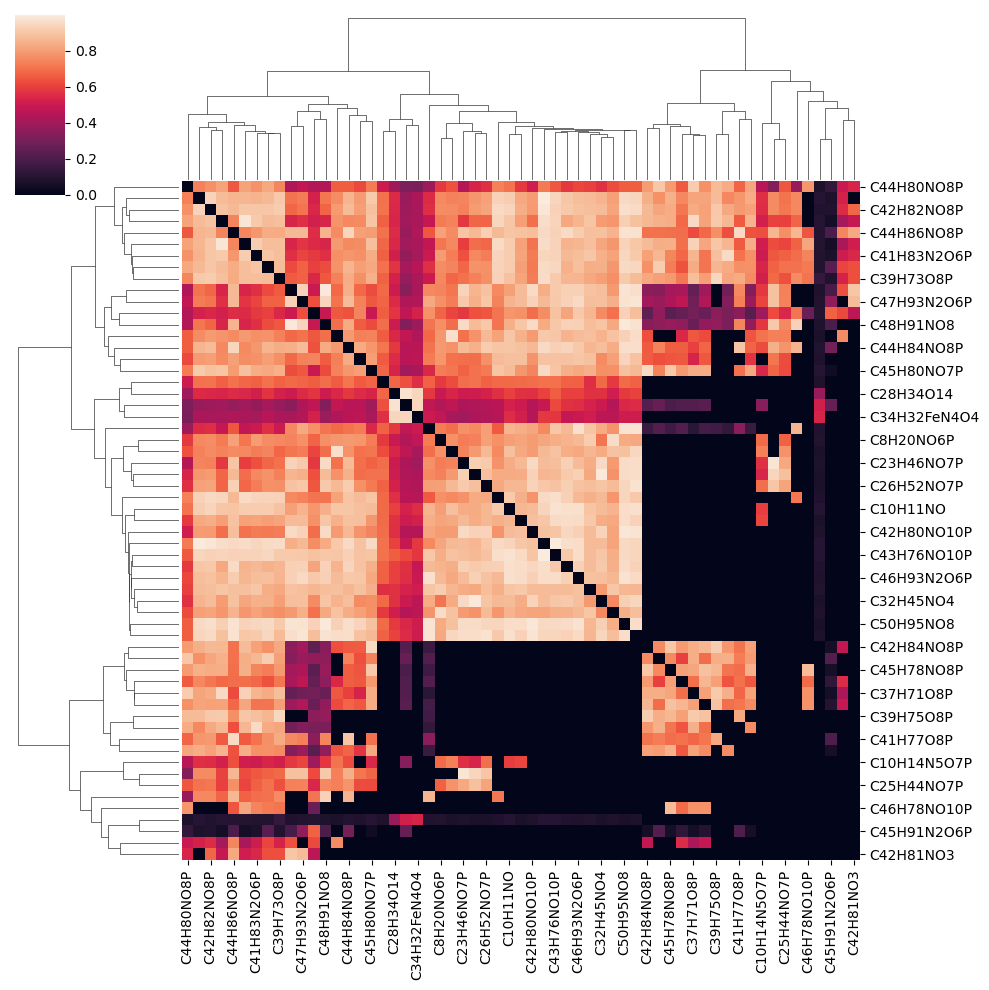

In [250]:
mean_d = {}
min_datasets = 10

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))

df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)

for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v

a = sns.clustermap(df)

In [265]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(df)


for x in df.columns[labels==2]:
    print(molecule_names[x])

['PS(15:0/22:4(7Z,10Z,13Z,16Z))', 'PS(22:4(7Z,10Z,13Z,16Z)/15:0)']
['3,4-Dihydro-4-[(5-methyl-2-furanyl)methylene]-2H-pyrrole', '3-[(5-Methyl-2-furanyl)methyl]-1H-pyrrole', '1-(2,3-Dihydro-1H-pyrrolizin-5-yl)-2-propen-1-one', '(R)-Boschniakine', 'Tryptophanol']
['LysoPE(22:4(7Z,10Z,13Z,16Z)/0:0)', 'LysoPE(0:0/22:4(7Z,10Z,13Z,16Z))']
['Pelargonidin 3-sophoroside']
['Glycerophosphocholine']
['PC(16:0/P-18:0)', 'PC(18:0/P-16:0)', 'PC(P-16:0/18:0)', 'PC(P-18:0/16:0)', 'PC(o-16:1(9Z)/18:0)', 'PC(o-18:1(11Z)/16:0)', 'PC(o-18:1(9Z)/16:0)']
['LysoPE(0:0/18:1(11Z))', 'LysoPE(0:0/18:1(9Z))', 'LysoPE(18:1(11Z)/0:0)', 'LysoPE(18:1(9Z)/0:0)']
['Thalidomide arene oxide', '5-Hydroxythalidomide', "cis,trans-5'-Hydroxythalidomide"]
['SM(d18:1/23:0)']
['Gymnodimine']
['Arabinosylhypoxanthine', 'Inosine', 'Allopurinol riboside']
['Galactosylceramide (d18:1/26:1(17Z))', 'Glucosylceramide (d18:1/26:1(17Z))']
['PE-NMe2(18:1(11Z)/15:0)', 'PE-NMe2(15:0/18:1(11Z))', 'PE-NMe2(15:0/18:1(9Z))', 'PE-NMe2(18:1(9Z)/

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## Coloc vs. co-occurrence

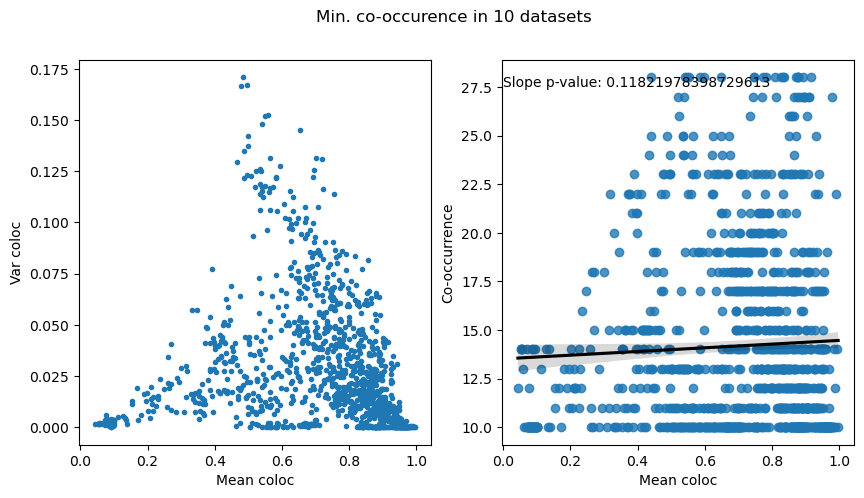

0.11821978398729613

In [306]:
mean_l = []
var_l = []
cv_l = []
cooc_l = []
min_datasets = 10

counter = 0
for x in ii_dict.values():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_l.append(np.mean(x))
            var_l.append(np.var(x))
            cv_l.append(np.std(x)/np.mean(x))
            cooc_l.append(len(x))
            counter += 1

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(mean_l, var_l, '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

fig.suptitle(f'Min. co-occurence in {min_datasets} datasets')

sns.regplot(x="mean", y="cooc", data=pd.DataFrame({'mean': mean_l, 'cooc': cooc_l}), ax=ax2, line_kws={"color": "black"})
#ax2.hist2d(mean_l, cooc_l)
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('Co-occurrence')
pval = stats.linregress(mean_l, cooc_l).pvalue
ax2.text(0.0, list(ax2.get_yticklabels()[-2].get_position())[1], f'Slope p-value: {pval}')
plt.show()

stats.linregress(mean_l, cooc_l).pvalue

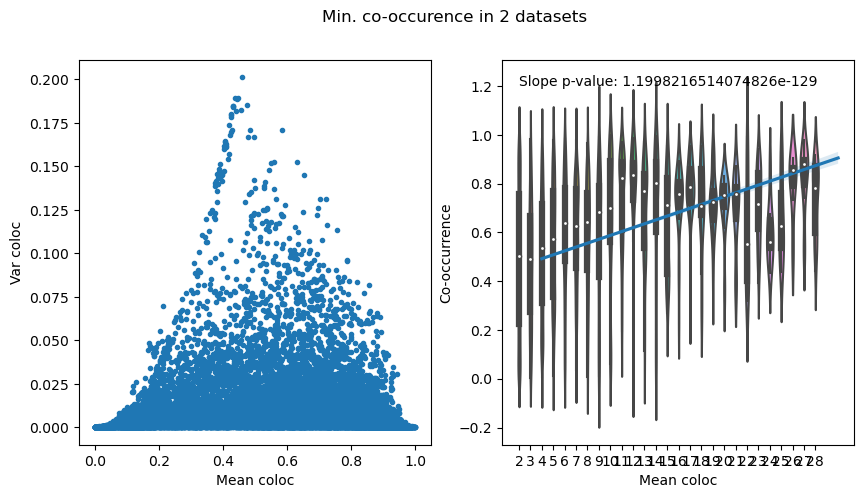

1.1998216514074826e-129

In [315]:
mean_l = []
var_l = []
cv_l = []
cooc_l = []
min_datasets = 2

counter = 0
for x in ii_dict.values():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_l.append(np.mean(x))
            var_l.append(np.var(x))
            cv_l.append(np.std(x)/np.mean(x))
            cooc_l.append(len(x))
            counter += 1

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(mean_l, var_l, '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

fig.suptitle(f'Min. co-occurence in {min_datasets} datasets')

sns.violinplot(x="cooc", y="mean", data=pd.DataFrame({'mean': mean_l, 'cooc': cooc_l}), ax=ax2)
sns.regplot(x="cooc", y="mean", data=pd.DataFrame({'mean': mean_l, 'cooc': cooc_l}), ax=ax2, scatter=False)

#ax2.hist2d(mean_l, cooc_l)
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('Co-occurrence')
pval = stats.linregress(cooc_l, mean_l).pvalue
ax2.text(0.0, list(ax2.get_yticklabels()[-2].get_position())[1], f'Slope p-value: {pval}')
plt.show()

stats.linregress(mean_l, cooc_l).pvalue

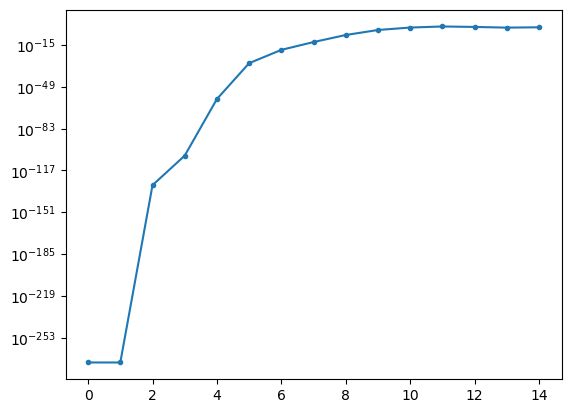

In [304]:
min_ds = []
pvals = []
for i in range(15):
    mean_l = []
    var_l = []
    cv_l = []
    cooc_l = []
    min_datasets = i

    counter = 0
    for x in ii_dict.values():
        if len(x) >= min_datasets:
            if not all(np.array(x)==0):
                mean_l.append(np.mean(x))
                var_l.append(np.var(x))
                cv_l.append(np.std(x)/np.mean(x))
                cooc_l.append(len(x))
                counter += 1
                
    if len(mean_l) > 2:
        pvals.append(stats.linregress(mean_l, cooc_l).pvalue)
        min_ds.append(min_datasets)
    
plt.plot(min_ds, pvals, '.-')
plt.yscale('log')

In [295]:
sns.regplot(x="mean", y="cooc", data=pd.DataFrame({'mean': mean_l, 'cooc': cooc_l}), ax=ax2, line_kws={"color": "black"})

25.0

## Coloc vs. LINEX

In [320]:
pd.Series(molecule_names)

C14H26N4O11P2                                         [Citicoline]
C15H17N5O6S2                                         [Cefpodoxime]
C21H14O10        [5,14-bis(acetyloxy)-4-hydroxy-9-oxo-8,17-diox...
C21H41O7P        [LysoPA(0:0/18:1(9Z)), LysoPA(18:1(9Z)/0:0), D...
C22H42O4              [Diethylhexyl adipate, Dioctyl hexanedioate]
                                       ...                        
C41H45O22        [Cyanidin 3-(6''-(E)-p-coumarylsambubioside) 5...
C43H80NO8P       [PE-NMe2(18:1(11Z)/18:2(9Z,12Z)), PE-NMe2(18:0...
C44H74O20                        [Capsianoside VI, Lyciumoside VI]
C44H78O13P2      [PGP(22:5(4Z,7Z,10Z,13Z,16Z)/16:0), PGP(22:5(7...
C46H76O13P2      [PGP(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:2(9Z,12Z))...
Length: 337, dtype: object

In [318]:
# LINEX2 preprocessing
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

### Todo:
* Compute datasets wise linex networks
* Plot coloc vs. linex neighborhoos
* After ranking make class wise comparisons of coloc vs. thei average connectivity in the network

In [321]:
parsed_lipids = lx2m.parse_annotation_series(adata.var[mol_names], 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = adata.var.copy()
parsed_annotations['parsed_lipids'] = parsed_lipids
parsed_annotations = parsed_annotations.loc[keep_annotations,:]


bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True
    )


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )



def catch_sp(g, source, target):
    try:
        return nx.shortest_path_length(g, source, target)
    except:
        return np.inf
    

ls = lipid_similarity
led = list(ig.edges)

edge_cor = []
nedge_cor = []

max_hops = 2

for l1 in range(len(ls.columns)):
    for l2 in range(l1+1, len(ls.columns)):
        if catch_sp(ig, ls.columns[l1], ls.columns[l2]) <= max_hops:
            edge_cor.append(ls.iloc[l1, l2])
        else:
            nedge_cor.append(ls.iloc[l1, l2])

tmp_dat = pd.concat([
    pd.DataFrame({'cor': edge_cor, 'type': 'Max '+str(max_hops)+' hop neighbors'}),
    pd.DataFrame({'cor': nedge_cor, 'type': 'No neighbors'}),
          ])

sns.violinplot(tmp_dat, x='type', y='cor')
plt.title('Max '+str(max_hops)+' hop neighborsvs not neighbors')
plt.show()

# Testing

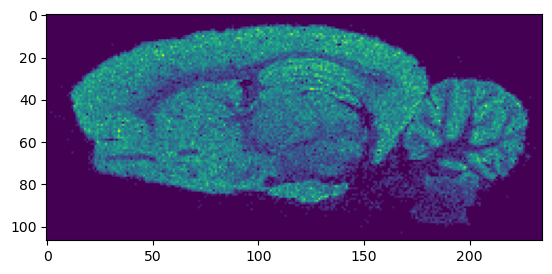

In [122]:
plt.imshow(tmp_array[237].reshape(adat.obs['y'].max()+1, -1))

In [ ]:
tmp = utils.coloc_preprocessing(brain_ads['2022-08-24_00h20m06s'])

In [84]:
adat.var

,formula,adduct,ionFormula,ion,mz,msm,rhoSpatial,rhoSpectral,moc,fdr,offSample,isotopeImages,colocCoeff,moleculeNames,moleculeIds,intensity
formula_adduct,,,,,,,,,,,,,,,,
C42H82NO8P+Na,C42H82NO8P,+Na,C42H82NO8PNa,C42H82NO8P+Na+,782.567090,0.942587,0.954109,0.981919,0.998802,0.033333,False,"[{'mz': 782.5670895885813, 'url': 'https://s3....",None,"[PC(14:0/20:1(11Z)), PC(14:1(9Z)/20:0), PC(16:...","[HMDB0007879, HMDB0007911, HMDB0007971, HMDB00...",172.843750
C42H82NO8P+K,C42H82NO8P,+K,C42H82NO8PK,C42H82NO8P+K+,798.541029,0.941862,0.982779,0.990116,0.998526,0.042857,False,"[{'mz': 798.5410294442759, 'url': 'https://s3....",None,"[PC(14:0/20:1(11Z)), PC(14:1(9Z)/20:0), PC(16:...","[HMDB0007879, HMDB0007911, HMDB0007971, HMDB00...",463.500000
C41H83N2O6P+K,C41H83N2O6P,+K,C41H83N2O6PK,C41H83N2O6P+K+,769.562095,0.922507,0.971342,0.975669,0.998405,0.042857,False,"[{'mz': 769.5620945400691, 'url': 'https://s3....",None,"[SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...","[HMDB0012088, HMDB0012089, HMDB0062559]",72.500000
C37H71O8P+K,C37H71O8P,+K,C37H71O8PK,C37H71O8P+K+,713.451867,0.907610,0.981760,0.980270,0.998728,0.042857,False,"[{'mz': 713.4518667581781, 'url': 'https://s3....",None,"[PA(16:0/18:1(11Z)), PA(16:0/18:1(9Z)), 9-Octa...","[HMDB0007858, HMDB0007859, HMDB0031130, HMDB01...",86.546875
C43H76NO7P+Na,C43H76NO7P,+Na,C43H76NO7PNa,C43H76NO7P+Na+,772.525223,0.905913,0.963896,0.977953,0.998662,0.059375,False,"[{'mz': 772.5252231593009, 'url': 'https://s3....",None,"[PE(20:4(5Z,8Z,11Z,14Z)/P-18:1(11Z)), PE(20:4(...","[HMDB0009413, HMDB0009414, HMDB0009446, HMDB00...",229.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C44H80O5+K,C44H80O5,+K,C44H80O5K,C44H80O5+K+,727.563789,0.667312,0.000292,0.826276,0.995035,0.199009,False,"[{'mz': 727.5637888022283, 'url': 'https://s3....",None,"[DG(22:1n9/0:0/18:2n6), DG(22:1(13Z)/19:2(10Z,...","[HMDB0056253, HMDB0116449]",0.748779
C48H84NO7P+K,C48H84NO7P,+K,C48H84NO7PK,C48H84NO7P+K+,856.561775,0.667181,0.009195,0.819448,0.991649,0.199009,False,"[{'mz': 856.5617748336741, 'url': 'https://s3....",None,"[PC(22:5(4Z,7Z,10Z,13Z,16Z)/P-18:1(11Z)), PC(2...","[HMDB0008687, HMDB0008688, HMDB0008720, HMDB00...",0.665894
C52H100NO8P+K,C52H100NO8P,+K,C52H100NO8PK,C52H100NO8P+K+,936.681905,0.666742,0.029271,0.806536,0.972113,0.199231,False,"[{'mz': 936.6819048453883, 'url': 'https://s3....",None,"[PC(20:1(11Z)/24:1(15Z)), PC(20:2(11Z,14Z)/24:...","[HMDB0008323, HMDB0008355, HMDB0008547, HMDB00...",0.865112


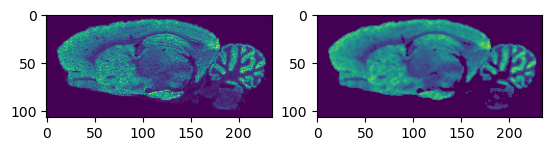

In [107]:
ds_id = '2022-07-19_19h29m24s'
conv_data = utils.coloc_preprocessing(brain_ads[ds_id])

fig, (ax1, ax2) = plt.subplots(ncols=2)

c = 2

ax1.imshow(brain_ads[ds_id].X.transpose().reshape((brain_ads[ds_id].X.shape[1], brain_ads[ds_id].obs['y'].max()+1, -1))[c])
ax2.imshow(conv_data.reshape((brain_ads[ds_id].X.shape[1], brain_ads[ds_id].obs['y'].max()+1, -1))[c])